Install all libraries and prerequisites

In [11]:
# tensorflow packages
!pip install absl-py
!pip install tensorflow
!pip install tensorflow-hub
# seaborn
!pip install seaborn
# ML
!pip install scikit-learn
# Facebook's pytorch
!pip install torch
# Hugging face
!pip install transformers datasets

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Load the libraries

In [1]:
# Normal packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

# Deep learning
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub

# Hugging Face
from transformers import pipeline

# Scikit-learn
from sklearn.cluster import KMeans

# NLP
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk

In [4]:
# Download some nltk required data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Michael
[nltk_data]     Cortes\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to C:\Users\Michael
[nltk_data]     Cortes\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

Load the deep Learning NLP Models (pretrained)

In [2]:
# Universal sentence encoder (from Google)
USE_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Function to use USE encoder
def embed(input):
    return np.array(USE_encoder(input))



In [4]:
# Get sentiment model from hugging face platform

sentiment_model = pipeline("sentiment-analysis")



No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [33]:
def sentiment(input):
    result = sentiment_model(input[:512])
    sign = 1 if(result[0]['label']=="POSITIVE") else -1
    value = result[0]['score']
    return sign*value

Load the data

In [11]:
df = pd.read_csv("drugLibTrain_raw.tsv", sep="\t")

df.shape

(3107, 9)

In [12]:
df.sample(10)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
385,2520,motrin,9,Considerably Effective,No Side Effects,severe headache,Ibuprofen generally took away the pain especia...,There did not seem to be any side effects of t...,I get severe headaches about every two or thre...
1773,1930,zithromax,1,Ineffective,No Side Effects,bronchitis,I didn't receive any treatment benefits from t...,none that I could identify,I was take this to deal with the infection in ...
786,2904,tramadol,3,Highly Effective,Severe Side Effects,pain relief (glenohumeral instability correction),Virtually no pain.,"Mental numbness, feebleness, lethargy, depress...","Due to the above mentioned side effects, I sto..."
1780,1633,premarin,10,Highly Effective,No Side Effects,hrt,Alleviation of post hysterectomy depression an...,Some headaches at the beginning of the treatme...,Three months after my hysterectomy in 1998 I w...
1142,737,flonase,10,Highly Effective,No Side Effects,allergies,This spray clears the nasal passages to promot...,I've experienced no side effects.,"Simply shake the bottle, and use 2 sprays in e..."
2104,2941,mirapex,9,Highly Effective,Mild Side Effects,restless leg syndrome,The benefits were remarkable and fast. Before...,The only side effect that the patient experien...,The patient developed restless leg syndrome ar...
1458,1693,retin-a-micro,3,Ineffective,Mild Side Effects,acne,None that I had experienced.,Redness the first week. Then acne got worse.,Decided to stop treatment after three months. ...
485,659,seasonique,2,Considerably Effective,Severe Side Effects,birth control,I assume this birth control prevented pregnanc...,I've been on seasonique for three months now a...,switched pills
1183,974,macrobid,1,Ineffective,Extremely Severe Side Effects,bladder infection,"No treatment benefit, because the complete pre...",The side effects were horrible after one dose ...,"Supposed to take 1 tablet every 12 hours, if I..."
2841,4017,celexa,10,Highly Effective,Mild Side Effects,anxiety and mild depression,Citalopram turned me into myself again. I didn...,In the first few weeks I felt a little shaky a...,This was perscribed by my gynocologist and I p...


Limit data to reviews we wish to build topics off of

In [13]:
# Look at only the side effects
sideEffectsReviews = df['sideEffectsReview'].dropna().tolist()



Create topic model

In [34]:
class ReviewsTopicModel:

    STOPWORDS = stopwords.words('english') # stopwords from ntlk

    EMBEDDING_DIM = 512 # USE encoder

    # Constructor
    def __init__(self, reviews):
        self.X = self.clean(reviews)

    # Clean text method
    def clean(self, reviews):
        # Words to replace
        string_map = {'\r': '', '\n': '', '/': ' ', "'": "", '"': ''}
        reviews_cleaned = reviews[:]
        for i in range(len(reviews_cleaned)):
            for s in string_map:
                reviews_cleaned[i] = reviews_cleaned[i].replace(s, string_map[s]).lower() 
        # Transform the reviews into embeddings dataframe
        X = embed(reviews_cleaned)
        X = pd.DataFrame(X)
        X.index = reviews_cleaned
        return X

    # Method to determine number of topics (a.k.a kmeans cluster number)
    def elbow_plot(self):
        cluster_sizes = list(range(1, 81))
        cluster_scores = []
        for n in cluster_sizes:
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(self.X)
            cluster_scores.append(kmeans.inertia_)
        plt.figure()
        plt.plot(cluster_sizes, cluster_scores)
        plt.show()

    # Method to extract topics from text data
    def create_topics(self, num_topics):
        # Cluster the reviews
        kmeans = KMeans(n_clusters=num_topics)
        kmeans.fit(self.X)

        # Create the final topics dataframe
        topics_df = self.X.copy()
        topics_df['topic'] = kmeans.labels_.copy()
        topics_df['topic'] = topics_df['topic'].astype(int)

        # Create summary keywords per topic
        topic_keywords = {}
        for topic in topics_df['topic'].unique():
            topic_reviews = topics_df.query("topic == {}".format(topic)).index.tolist()
            topic_centroid = kmeans.cluster_centers_[topic] # cluster center
            topic_keywords[topic] = self.get_closest_words(topic_reviews, topic_centroid)
        topics_df['topic_keywords'] = topics_df['topic'].map(topic_keywords)

        # Score the sentiment of each review
        topics_df['sentiment'] = [sentiment(r) for r in topics_df.index.values.tolist()]

        # Final result
        self.topics_keywords = topic_keywords
        self.topics_df = topics_df.copy()[['topic', 'topic_keywords', 'sentiment']]


    def get_closest_words(self, reviews, centroid):
        word_distances = {}
        for r in reviews:
            review_words = [w for w in word_tokenize(r) if(w not in self.STOPWORDS)]
            for w in review_words:
                word_embedding = embed([w]) # return 512 dimensional vector for the word 'w'
                # how similar is the word embedding to the topic's centroid (avg of the cluster sample's embeddings)
                word_distances[w] = self.cosine_similarity(word_embedding, centroid) # 1 it means match, closer to 0 means different
        # done collecting the distances of the words to the topic's center
        top_5_keywords = sorted([(word_distances[w], w) for w in word_distances])[-5:]
        return ",".join([x[1] for x in top_5_keywords])

    def cosine_similarity(self, x, y):
        # x,y are both the appropriate dimension
        x = x.reshape(self.EMBEDDING_DIM,)
        y = y.reshape(self.EMBEDDING_DIM,)
        # calculate cosine similarity
        dotproduct = x.dot(y)
        x_mag = x.dot(x)**0.5
        y_mag = y.dot(y)**0.5
        # returns closer to 1 if x and y are similar, closer to 0 if they are different
        return dotproduct/(x_mag * y_mag)






Initialize model

In [35]:
topic_model = ReviewsTopicModel(sideEffectsReviews)

Create elbow plot to determine optimal number of topics (i.e. clusters)

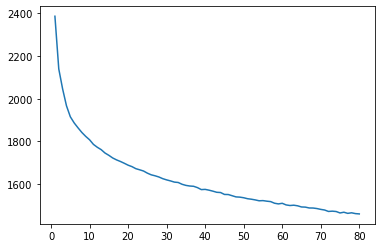

In [19]:
topic_model.elbow_plot() # going to use 40 clusters i.e. 40 topics

Create final model and evaluate

In [36]:
topic_model.create_topics(num_topics=40)

In [62]:
topic_model.topics_keywords[35]

'cravings,pounds,swelling,gaining,weight'

In [63]:
topic_model.topics_df.query("topic == 24")

,topic,topic_keywords,sentiment
"low sex drive, before i started taking this drug i was 19 years of age and full of enthousiasm. now engaged and 21 years old, my sex drive is very low, my wife and i are very unsatisfied. i am also very tired even during peak hours throughout the day, and its hard to concentrate on mundain tasks",24,"horny,moodiness,impotence,erectile,libido",-0.999543
"i have occasional night sweats, very vivid dreams and almost no sexual desire.",24,"horny,moodiness,impotence,erectile,libido",0.977285
"the problem for me if my strange dreams. plus, my sexuality is not that good anymore because i can not have orgasum! thats not that cool...",24,"horny,moodiness,impotence,erectile,libido",-0.999780
"occasional headaches and nausea,occasional ticking noise in the back of my head, and decreased sex drive,",24,"horny,moodiness,impotence,erectile,libido",-0.997408
"the side effects for me included slightly lowered sex drive but not completely gone and climax is still possible. i am drowsier on this drug than i was before and have lost some of my motivation regarding goals and dreams. however, it is worth it to also lose the insomnia and crying spells.",24,"horny,moodiness,impotence,erectile,libido",-0.682033
...,...,...,...
could no longer have orgasms,24,"horny,moodiness,impotence,erectile,libido",0.560126
not too interested in sex anymore.,24,"horny,moodiness,impotence,erectile,libido",-0.999043
"no negative side effects. improved skin, more libido, iwere side benefits.",24,"horny,moodiness,impotence,erectile,libido",0.998465
"weight gain, extreme tiredness during the day, insomnia at night, bad effect on libido and sexual ability. extreme lethargy.",24,"horny,moodiness,impotence,erectile,libido",-0.999365


Look at average sentiment per topic

In [67]:
topic_model.topics_df.groupby(['topic', 'topic_keywords']).agg({'sentiment': 'mean'}).reset_index()\
    .sort_values(by='sentiment')

,topic,topic_keywords,sentiment
1,1,",,.,whatsoever,nil,none",-0.985667
20,20,"nauseas,nauseous,nauseated,nausea,nausea-",-0.964721
22,22,"headaches,sickness,vomiting,nauseous,nausea",-0.961007
18,18,"nystatin,vaginitis,yeast,thrush,diflucan",-0.933440
25,25,"tendonitis,pain,aching,fibromyalgia,pains",-0.931612
9,9,"prilosec,stomach,nauseated,nexium,gastritis",-0.927430
7,7,"5mg,cipro,laxitive,prednisone,side-effects",-0.917449
28,28,"itching,hives,rash,rashes,itchiness",-0.917218
8,8,"migraines,migrains,migraine,headache,headaches",-0.911727
32,32,"dizzyness,light-headedness,lightheadedness,diz...",-0.903786


In [68]:
topic_model.topics_df.query("topic == 19")

,topic,topic_keywords,sentiment
there were no side effects,19,"none,effect,affects,adverse,effects",0.521258
the treatment had no side effect on me.,19,"none,effect,affects,adverse,effects",-0.992483
there was no side effects to this treatment.,19,"none,effect,affects,adverse,effects",0.871121
no negative side effects were experienced.,19,"none,effect,affects,adverse,effects",0.990023
no negative side effects,19,"none,effect,affects,adverse,effects",0.992613
...,...,...,...
no side effects noticed.,19,"none,effect,affects,adverse,effects",-0.993321
no side effects.,19,"none,effect,affects,adverse,effects",-0.851230
there are absolutely no side effects,19,"none,effect,affects,adverse,effects",-0.544019
there were no side effects.,19,"none,effect,affects,adverse,effects",0.894721
